In [1]:
from logging import getLogger
import torch

from rnn_excersise.data import DataLoader
from rnn_excersise.train import Train


logger = getLogger(__name__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## データの読み込み・確認

1. kaggleコマンドを用いてデータセットをダウンロードする
2. DataLoaderクラスでデータセットを読み込む

In [2]:
# カレントディレクトリにmyanimelist-dataset.zipがない場合はダウンロード
![ ! -f ./myanimelist-dataset.zip] && kaggle datasets download -d dbdmobile/myanimelist-dataset

/bin/bash: 0 行: [: `]'がありません


In [3]:
# データの読み込み
loader = DataLoader("data", "anime-dataset-2023.csv", "English name")
loader.load_data()
data = loader.parse_data(device)

## モデルの訓練
パラメータを設定してモデルを訓練する

In [4]:
# モデルの訓練
learning_rate = 0.001
n_iters = 10000
max_norm = 5
num_layers = 2

logger.info(f"learning_rate: {learning_rate}")
logger.info(f"n_iters: {n_iters}")
logger.info(f"max_norm: {max_norm}")
logger.info(f"num_layers: {num_layers}")

trainer = Train(
    data,
    device,
    logger,
    n_hidden=128,
    learning_rate=learning_rate,
    num_layers=num_layers,
)
trained_model, all_losses = trainer.proceed(
    retrain=True, n_iters=n_iters, max_norm=max_norm
)

Output()

## モデルの検証


Output()

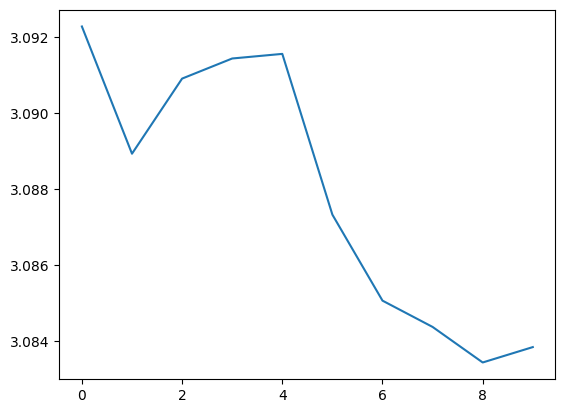

/home/s.nanako/workspace/RNN_tutorial/src/rnn_excersise/plot.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + genres_list, rotation=90)
/home/s.nanako/workspace/RNN_tutorial/src/rnn_excersise/plot.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + genres_list)


<Figure size 640x480 with 0 Axes>

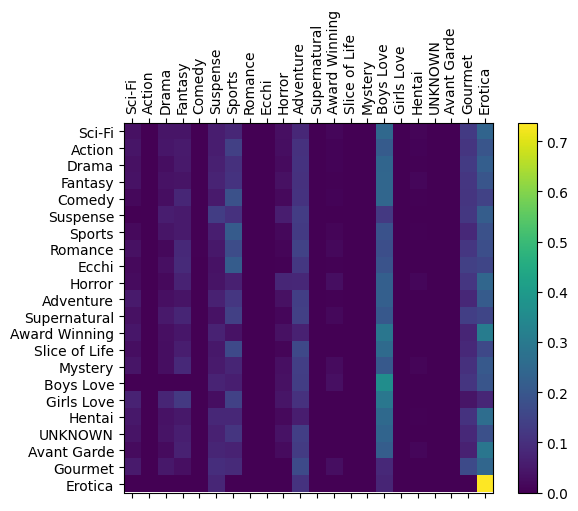

In [9]:
from pathlib import Path
from rich.progress import track
from rnn_excersise.plot import plot_all_losses, plot_confusion_matrix
from rnn_excersise.predict import evaluate


n_confusion = 10000
confusion = torch.zeros(data.n_genres, data.n_genres).to(device)
save_path = "result"

# ディレクトリがない場合は作成
if not Path(save_path).exists():
    Path(save_path).mkdir()

for i in track(range(n_confusion), description="Confusion Matrix"):
    category, line, category_tensor, line_tensor = data.randomTrainingExample()
    output = evaluate(trained_model, line_tensor.to(device))
    guess, guess_i = data.categoryFromOutput(output)
    category_i = data.genres_list.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(data.n_genres):
    confusion[i] = confusion[i] / confusion[i].sum()

plot_all_losses(all_losses)
plot_confusion_matrix(confusion.to("cpu"), data.genres_list)

## モデルのテスト

In [13]:
from rnn_excersise.predict import predict

input_data = "The story of a Cat"
predict(input_data, trained_model, data, n_predictions=10)


> The story of a Cat
(-2.99) Erotica
(-3.01) Boys Love
(-3.03) Fantasy
(-3.03) Award Winning
(-3.05) Comedy
(-3.06) Supernatural
(-3.06) Sci-Fi
(-3.08) Adventure
(-3.08) Mystery
(-3.09) Hentai
